Importing the Libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import sklearn.model_selection as skt
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

Importing and preprocessing the data

In [2]:
dataurl  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(dataurl,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']
data = data.replace('?',np.nan).dropna()
#data

In [3]:
#Z scoring
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex','fbs','exang','DISEASE'])
cols2zscore

for c in cols2zscore:
  d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
  data[c] = (d - d.mean())/d.std(ddof=1)

In [4]:
#binarizing the data (a person have a diseases or not have a diseases)
data['DISEASE'][data['DISEASE']>0] = 1

C:\Users\user\AppData\Local\Temp\ipykernel_20128\3740208473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DISEASE'][data['DISEASE']>0] = 1


Creating the data loders and spliting them into train and test data

In [5]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[data.keys().drop('DISEASE')].values ).float()
labels = torch.tensor( data['DISEASE'].values ).float()

print( dataT.shape )
print( labels.shape )

# we'll actually need the labels to be a "matrix"
labels = labels[:,None]
print( labels.shape )

torch.Size([297, 13])
torch.Size([297])
torch.Size([297, 1])


In [6]:
train_data,test_data, train_labels,test_labels = skt.train_test_split(dataT, labels, test_size=50)

# then convert them into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
trainLoader = DataLoader(train_data,batch_size=20,shuffle=True,drop_last=True)
testLoader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Creating the Main model and train function

In [7]:
# Net creation
def createpredictionNet():
    class predictionNet(nn.Module):
        def __init__(self):
            super().__init__()
            ##input
            self.input = nn.Linear(13,32)

            ##hidden
            self.h1 = nn.Linear(32,64)
            self.h2 = nn.Linear(64,10)
            
            ##ouput
            self.output = nn.Linear(10,1) 


        def forward(self,X):
            X = F.relu(self.input(X))
            X = F.relu(self.h1(X))
            X = F.relu(self.h2(X))
             
        
            return self.output(X)

    net = predictionNet()

    #lossfuncttion
    lossfun = nn.BCEWithLogitsLoss()

    #optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=.01)

    return net,lossfun,optimizer


In [15]:
#Traning function

def trainNet():
    numepochs =100
    net,lossfun,optimizer = createpredictionNet()

    # storage for losses and accuracy 
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    testAcc   = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()
        # loop over training data batches
        
        batchLoss = []
        
        for X,Y_in in trainLoader:

           #forward pass
           Y_out = net(X)
        
           loss = lossfun(Y_out,Y_in)

           #backprop
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()

           #batch loss and traning accuraacy after every batch 

           batchLoss.append(loss.item()) 
           predictions = (torch.sigmoid(Y_out)>.5).float()
           trainAcc[epochi] = 100*torch.mean((predictions==Y_in).float())

        trainLoss[epochi] = np.mean(batchLoss)

        net.eval()
        for x,y_in in testLoader:
            y_out = net(x)
            loss = lossfun(y_out,y_in)
            testLoss[epochi] = loss.item()
            # test accuracy
            predictions = (torch.sigmoid(y_out)>.5).float()
            testAcc[epochi] = 100*torch.mean((predictions==y_in).float())
  
        


    return trainAcc,testAcc,trainLoss,testLoss,net  

Creating the new model

In [16]:
trainAcc,testAcc,trainLoss,testLoss,net    = trainNet()

Viualizing the output

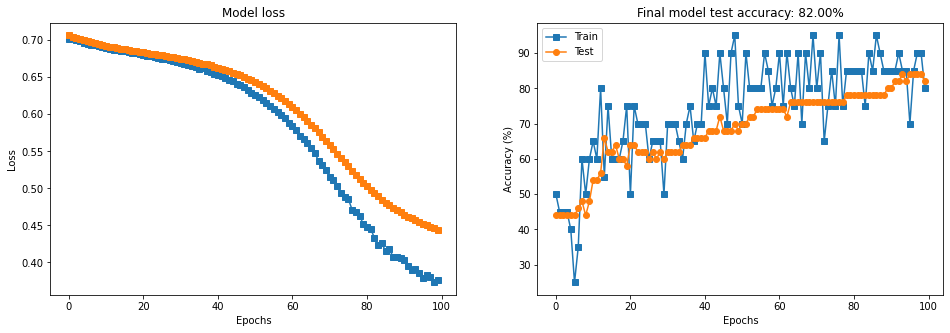

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'s-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()